# Sensor Data Analysis

Analyse raw sensor data from PhysioNet: https://physionet.org/physiobank/database/noneeg/

Data: "Bag of Sensors"

Feature Extraction
- Statistical
- Continuous
- Spectral

Modeling

## Load Data

Each subject has several datafiles:
- SubjectN_AccTempEDA.atr: annotation
- SubjectN_AccTempEDA.dat: data
- SubjectN_AccTempEDA.hea: header
- SubjectN_Sp02HR.dat: data
- SubjectN_Sp02HR.hea: header

These files are in the WFDB format, and can be read using the `wfdb` python module.
(https://github.com/MIT-LCP/wfdb-python)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

# pip install wfdb
import wfdb

# render plots inline
%matplotlib inline

### Acc Temp EDA

In [3]:
ann = wfdb.rdann('./data/physionet/Subject10_AccTempEDA', extension='atr', summarize_labels=True)
print(ann.__dict__)

{'record_name': 'Subject10_AccTempEDA', 'extension': 'atr', 'sample': array([    1,  2401,  5010,  7411,  7732, 10573, 12974, 15839]), 'symbol': ['"', '"', '"', '"', '"', '"', '"', '"'], 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0, 0, 0, 0]), 'num': array([0, 0, 0, 0, 0, 0, 0, 0]), 'aux_note': ['Relax', 'PhysicalStress', 'Relax', 'EmotionalStress', 'CognitiveStress', 'Relax', 'EmotionalStress', 'Relax'], 'fs': 8, 'label_store': None, 'description': None, 'custom_labels': None, 'contained_labels':     label_store symbol         description
22           22      "  Comment annotation, 'ann_len': 8}


{'record_name': 'Subject10_AccTempEDA', 'n_sig': 5, 'fs': 8, 'counter_freq': None, 'base_counter': None, 'sig_len': 18239, 'base_time': None, 'base_date': None, 'comments': ['age: 23', 'gender: M', 'height/cm: 180', 'weight/kg: 64'], 'sig_name': ['ax', 'ay', 'az', 'temp', 'EDA'], 'p_signal': array([[ 4.49967956e-01, -1.00996857e+00, -4.00036622e-02,
         2.70000641e+01,  3.25101413e+00],
       [ 4.39992676e-01, -1.01998718e+00, -4.00036622e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -1.01998718e+00, -5.00045778e-02,
         2.70000641e+01,  3.25605237e+00],
       ...,
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['Subject1

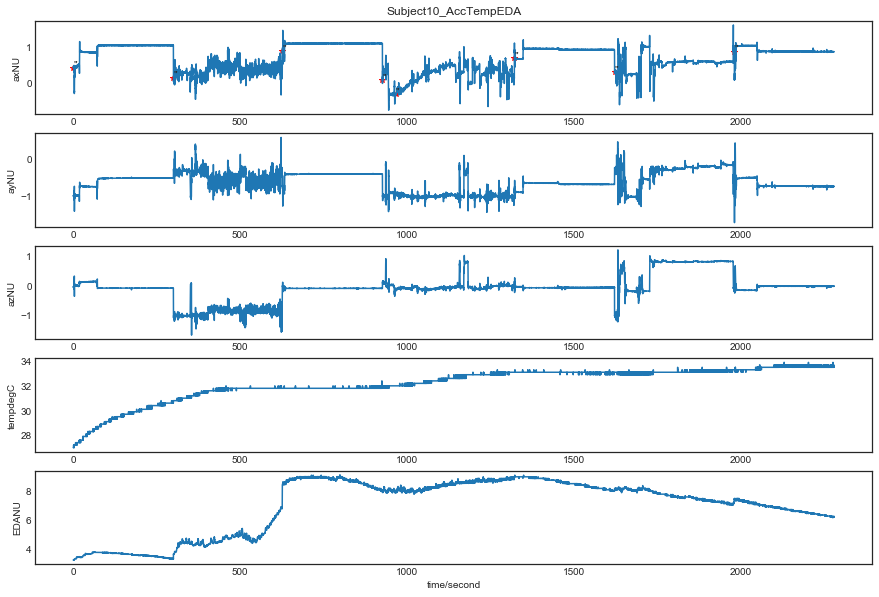

In [4]:
record_acc_temp_eda = wfdb.rdrecord('./data/physionet/Subject10_AccTempEDA')
print(record_acc_temp_eda.__dict__)

wfdb.plot_wfdb(record=record_acc_temp_eda, title='Subject10_AccTempEDA', annotation=ann, plot_sym=True, 
               time_units='seconds', figsize=(15, 10))

In [5]:
data_acc_temp_eda = record_acc_temp_eda.p_signal
data_acc_temp_eda.shape

(18239, 5)

### SpO2 HR

{'record_name': 'Subject10_SpO2HR', 'n_sig': 2, 'fs': 1, 'counter_freq': None, 'base_counter': None, 'sig_len': 2286, 'base_time': None, 'base_date': None, 'comments': ['age: 23', 'gender: M', 'height/cm: 180', 'weight/kg: 64'], 'sig_name': ['SpO2', 'hr'], 'p_signal': array([[96.99995422, 95.99990844],
       [95.99993896, 95.99990844],
       [95.99993896, 96.9999237 ],
       ...,
       [95.99993896, 69.00027467],
       [95.99993896, 68.00025941],
       [95.99993896, 67.00024415]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['Subject10_SpO2HR.dat', 'Subject10_SpO2HR.dat'], 'fmt': ['16', '16'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [13106.8, 1284.98039216], 'baseline': [-1251699, -112435], 'units': ['%', 'bpm'], 'adc_res': [16, 16], 'adc_zero': [0, 0], 'init_value': [19660, 10923], 'checksum': [39424, 34156], 'block_size': [0, 0]}


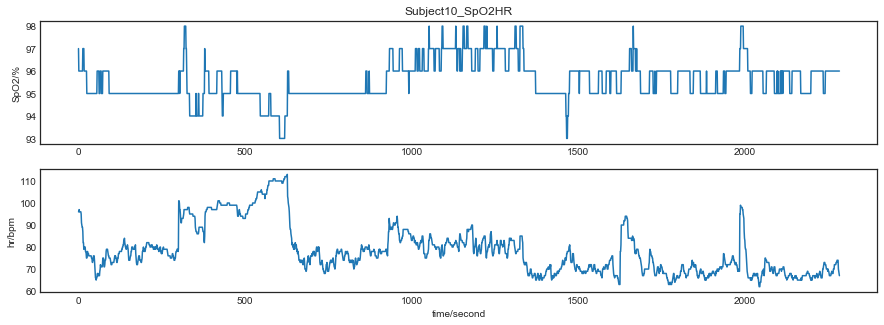

In [6]:
record_spo2_hr = wfdb.rdrecord('./data/physionet/Subject10_SpO2HR')
print(record_spo2_hr.__dict__)

wfdb.plot_wfdb(record=record_spo2_hr, title='Subject10_SpO2HR', time_units='seconds', figsize=(15, 5))

In [7]:
data_spo2_hr = record_spo2_hr.p_signal
data_spo2_hr.shape

(2286, 2)

In [8]:
# number of acceleration, etc samples per second
record_acc_temp_eda.fs

8

In [9]:
# number of SpO2 and HR samples per second
record_spo2_hr.fs

1

## Aligning data of different frequencies

The two dataset frequencies (number of samples per second) are different.

To support processing both datasets at the same time, we need to match the frequencies.

This is a common situation when taking readings from different sensors or data sources.

Two strategies:
1. Upsampling the smaller frequency data. E.g: repeat samples or interpolate.
2. Downsampling the larger frequency data. E.g: replace with mean or median.

Which one to pick depends on requirements: whether you need to maintain precision of the higher frequency dataset.

Example: https://machinelearningmastery.com/resample-interpolate-time-series-data-python/

### Option 1: Upsampling SpO2 HR to 8 samples per second

In [10]:
# create an index with 1 second timestamps, using the length of data_spo2_hr
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.period_range.html
#
# frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

# for this dataset, the start date is just an arbitrary reference
per_second_index = pd.period_range(start='2019-01-01', periods=len(data_spo2_hr), freq='S')
per_second_index

PeriodIndex(['2019-01-01 00:00:00', '2019-01-01 00:00:01',
             '2019-01-01 00:00:02', '2019-01-01 00:00:03',
             '2019-01-01 00:00:04', '2019-01-01 00:00:05',
             '2019-01-01 00:00:06', '2019-01-01 00:00:07',
             '2019-01-01 00:00:08', '2019-01-01 00:00:09',
             ...
             '2019-01-01 00:37:56', '2019-01-01 00:37:57',
             '2019-01-01 00:37:58', '2019-01-01 00:37:59',
             '2019-01-01 00:38:00', '2019-01-01 00:38:01',
             '2019-01-01 00:38:02', '2019-01-01 00:38:03',
             '2019-01-01 00:38:04', '2019-01-01 00:38:05'],
            dtype='period[S]', length=2286, freq='S')

In [11]:
# create a dataframe for SpO2 data using the above period index
df_spO2_hr = pd.DataFrame(data_spo2_hr, index=per_second_index, columns=record_spo2_hr.sig_name)
df_spO2_hr.head()

,SpO2,hr
2019-01-01 00:00:00,96.999954,95.999908
2019-01-01 00:00:01,95.999939,95.999908
2019-01-01 00:00:02,95.999939,96.999924
2019-01-01 00:00:03,95.999939,95.999908
2019-01-01 00:00:04,95.999939,95.999908


In [12]:
# upsample to match the frequency of the other data (8 times)

In [13]:
factor = record_acc_temp_eda.fs / record_spo2_hr.fs
factor

8.0

In [14]:
# resample, then interpolate
# Note: whether interpolation makes sense depends on the sensor and type of data
upsampled = df_spO2_hr.resample('125ms')

df_upsampled = upsampled.interpolate()
df_upsampled.head(10)

,SpO2,hr
2019-01-01 00:00:00.000,96.999954,95.999908
2019-01-01 00:00:00.125,96.874952,95.999908
2019-01-01 00:00:00.250,96.749950,95.999908
2019-01-01 00:00:00.375,96.624949,95.999908
2019-01-01 00:00:00.500,96.499947,95.999908
2019-01-01 00:00:00.625,96.374945,95.999908
2019-01-01 00:00:00.750,96.249943,95.999908
2019-01-01 00:00:00.875,96.124941,95.999908
2019-01-01 00:00:01.000,95.999939,95.999908
2019-01-01 00:00:01.125,95.999939,96.124910


In [15]:
df_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18288 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:38:05.875
Freq: 125L
Data columns (total 2 columns):
SpO2    18288 non-null float64
hr      18288 non-null float64
dtypes: float64(2)
memory usage: 428.6 KB


In [16]:
# Note: there are fewer values in the Acc dataframe, so we need to ignore the
# later entries from df_upsampled.

df_acc_temp_eda = pd.DataFrame(data_acc_temp_eda, columns=record_acc_temp_eda.sig_name)
df_acc_temp_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18239 entries, 0 to 18238
Data columns (total 5 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
dtypes: float64(5)
memory usage: 712.5 KB


In [17]:
df_acc_temp_eda.index = df_upsampled.index[:len(df_acc_temp_eda)]
df_acc_temp_eda.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18239 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:37:59.750
Freq: 125L
Data columns (total 5 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
dtypes: float64(5)
memory usage: 855.0 KB


In [18]:
# concatenate the two dataframes, column-wise
df_option1 = pd.concat([df_acc_temp_eda, df_upsampled], axis=1).dropna()
df_option1.head()

,ax,ay,az,temp,EDA,SpO2,hr
2019-01-01 00:00:00.000,0.449968,-1.009969,-0.040004,27.000064,3.251014,96.999954,95.999908
2019-01-01 00:00:00.125,0.439993,-1.019987,-0.040004,27.000064,3.256052,96.874952,95.999908
2019-01-01 00:00:00.250,0.449968,-1.019987,-0.050005,27.000064,3.256052,96.749950,95.999908
2019-01-01 00:00:00.375,0.449968,-1.009969,-0.040004,27.000064,3.256052,96.624949,95.999908
2019-01-01 00:00:00.500,0.439993,-1.009969,-0.050005,27.000064,3.256052,96.499947,95.999908


In [19]:
df_option1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18239 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:37:59.750
Freq: 125L
Data columns (total 7 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
SpO2    18239 non-null float64
hr      18239 non-null float64
dtypes: float64(7)
memory usage: 1.1 MB


In [ ]:
# https://stackoverflow.com/questions/48126330/python-int-too-large-to-convert-to-c-long-plotting-pandas-dates
df_option1.index = pd.to_datetime(df_option1.index.to_timestamp())

df_option1.plot(figsize=(15, 10))
ax = plt.gca()
ax.set_title('Upsampled Data')
plt.show()

In [ ]:
df_option1.info()

### Option 2: Downsampling Acc Temp EDA to 1 sample per second

In [ ]:
# create an index with 125 millisecond timestamps, using the length of data_acc_temp_eda
#
# frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

# for this dataset, the start date is just an arbitrary reference
per_125_ms_index = pd.period_range(start='2019-01-01', periods=len(data_acc_temp_eda), freq='125ms')
per_125_ms_index

In [ ]:
# create a dataframe for Acc Temp EDA using the 125ms period index
df_acc_temp_eda2 = pd.DataFrame(data_acc_temp_eda, index=per_125_ms_index, columns=record_acc_temp_eda.sig_name)
df_acc_temp_eda2.head()

In [ ]:
# downsample using median
df_acc_temp_eda_downsampled = df_acc_temp_eda2.resample('S').median()
df_acc_temp_eda_downsampled.head(10)

In [ ]:
df_acc_temp_eda_downsampled.info()

In [ ]:
df_spo2_hr2 = pd.DataFrame(data_spo2_hr, columns=record_spo2_hr.sig_name, index=per_second_index)
df_spo2_hr2.info()

In [ ]:
# concatenate the two dataframes, column-wise
df_option2 = pd.concat([df_acc_temp_eda_downsampled, df_spo2_hr2], axis=1).dropna()
df_option2.head()

In [ ]:
df_option2.info()

In [ ]:
# Not needed, but for consistency with df_option1
df_option2.index = pd.to_datetime(df_option2.index.to_timestamp())

df_option2.plot(figsize=(15, 10))
ax = plt.gca()
ax.set_title('Downsampled Data')
plt.show()

In [ ]:
# Let's zoom into a 1-second time window and compare the plots

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

df_option1[(df_option1.index >= '2019-01-01 00:05') & (df_option1.index < '2019-01-01 00:06')].plot(ax=ax1)
ax1.set_title('Upsampled (with interpolation)')
df_option2[(df_option2.index >= '2019-01-01 00:05') & (df_option2.index < '2019-01-01 00:06')].plot(ax=ax2)
ax2.set_title('Downsampled (with median)')
plt.show()

## Statistical Features

In [ ]:
df.mean() # mean of each column

In [ ]:
df.median() # median is less sensitive to outliers than mean

In [ ]:
df.std() # standard deviation

In [ ]:
df.max()

In [ ]:
df.min()

In [ ]:
df.columns

### Discretise into quantiles

In [ ]:
df.ax.values.ravel() # raw values

In [ ]:
df['ax_q10'] = pd.qcut(df.ax.values.ravel(), 10, labels=False)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
df['ax_q10'].plot(ax=ax)
plt.show()

In [ ]:
# histogram showing distribution in the 10 levels
df['ax_q10'].hist()

In [ ]:
df['ay_q10'] = pd.qcut(df.ay.values.ravel(), 10, labels=False)
df['az_q10'] = pd.qcut(df.az.values.ravel(), 10, labels=False)